In [1]:
import numpy as np
import cv2,glob,random,os,shutil,copy,time

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,random_split,Dataset, ConcatDataset  
from PIL import Image
# from models import *
from tqdm import tqdm
import matplotlib.pyplot as plt
# from preprocess import *
import torch,torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler

random.seed(40)
np.random.seed(40)
torch.manual_seed(0)

/home/aminul/anaconda3/envs/torch_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DFNAME = 'at_unet'
device = torch.device('cuda:0')

modelname = 'at_unet'
n_epochs = 20
batch_size = 8

In [3]:
class DataLoaderSegmentation(Dataset):
    def __init__(self, folder_path, transform=None):
        super(DataLoaderSegmentation, self).__init__()
        
        self.transform = transform
        self.img_files = glob.glob(os.path.join(folder_path,'processed_image','*.jpg'))
        self.mask_files = []
        for img_path in self.img_files:
             self.mask_files.append(os.path.join(folder_path,'processed_mask',os.path.basename(img_path))) 

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data =   Image.open(img_path) #    use opencv or pil read image using img_path
            label =  Image.open(mask_path) #    use opencv or pil read label  using mask_path
            
            
            image = self.transform((data))
            mask = self.transform((label))
                
            return image,mask

    def __len__(self):
        return len(self.img_files)

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((512,512)),
    # transforms.RandomResizedCrop(200),
    # transforms.RandomHorizontalFlip(0.5),
    # transforms.RandomHorizontalFlip(0.5),
    # transforms.RandomRotation(30),
    transforms.ToTensor()
])

In [6]:
dataset = DataLoaderSegmentation('./segmentation_data/',train_transform)
train_set, test_set = random_split(dataset,[int(len(dataset)*0.9), int(len(dataset)*0.1)+1],
                                  generator=torch.Generator().manual_seed(0))

In [7]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

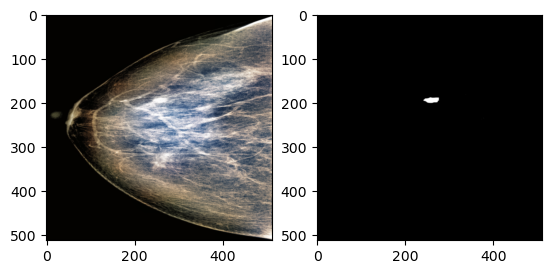

In [9]:
d = iter(train_loader)

x,y = next(d)

idx = 5
plt.subplot(1,2,1)
plt.imshow(x[idx].permute(1,2,0),cmap='gray')
plt.subplot(1,2,2)
plt.imshow(y[idx].squeeze(),cmap='gray')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from collections import defaultdict
import torch.nn.functional as F
import torch
from loss import dice_loss

best_loss = 10000000

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    
    
    
def train(model, train_loader, optim, scheduler, device, epochs):    
    model.train()
    metrics = defaultdict(float)
    epoch_samples = 0
    for i,(images,labels) in enumerate(tqdm(train_loader)):
        images, labels = images.to(device), labels.to(device)
        optim.zero_grad()
        outputs = model(images)
        loss = calc_loss(outputs, labels, metrics)
        
        loss.backward()
        optim.step()
        scheduler.step()
        epoch_samples += images.size(0)
    print_metrics(metrics, epoch_samples, 'train')
    epoch_loss = metrics['loss'] / epoch_samples
    
    
def test(model, test_loader, device, epochs):    
    model.eval()
    global best_loss
    metrics = defaultdict(float)
    epoch_samples = 0
    with torch.no_grad():
        for i,(images,labels) in enumerate(tqdm(test_loader)):
            images, labels = images.to(device), labels.to(device)
            # optim.zero_grad()
            outputs = model(images)
            loss = calc_loss(outputs, labels, metrics)
            epoch_samples += images.size(0)
        print_metrics(metrics, epoch_samples, 'test')
        epoch_loss = metrics['loss'] / epoch_samples    
        
        if loss < best_loss:
            print('Saving Best model...')
            state = {
                        'model':model.state_dict(),
                        'loss':loss,
                        'epoch':epochs,
                }

            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            save_point = './checkpoint/'
            if not os.path.isdir(save_point):
                os.mkdir(save_point)

            torch.save(state, save_point+modelname+'model.pth.tar')
            best_loss = loss
            

In [ ]:
num_class = 1

model = attention_unet(num_class).to(device)

In [ ]:
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)        

for i in range(n_epochs):

    train(model, train_loader, optimizer_ft, exp_lr_scheduler, device, i)
    test(model, test_loader, device, i)

In [ ]:
model.eval()   # Set model to evaluate mode

inputs, masks = next(iter(test_loader))
inputs = inputs.to(device)
masks = masks.to(device)

pred = model(inputs)
pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()
print(pred.shape)

In [ ]:
idx = 0

plt.subplot(1,2,1)
plt.imshow(masks[idx].cpu().squeeze(),cmap='gray')
plt.subplot(1,2,2)
plt.imshow(pred[idx].squeeze(),cmap='gray')